# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

605

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
responses = []
url = 'https://api.openweathermap.org/data/2.5/weather'
for city in cities:
    print(f'Hitting OpenWeather API for {city.title()}')
    params = {
        'q': city,
        'appid': weather_api_key
    }

    responses.append(requests.get(url, params))

Hitting OpenWeather API for Avarua
Hitting OpenWeather API for Ancud
Hitting OpenWeather API for Illoqqortoormiut
Hitting OpenWeather API for Montepuez
Hitting OpenWeather API for Vaitupu
Hitting OpenWeather API for Port Moresby
Hitting OpenWeather API for Cape Town
Hitting OpenWeather API for Khakhea
Hitting OpenWeather API for Marcona
Hitting OpenWeather API for Meulaboh
Hitting OpenWeather API for Albany
Hitting OpenWeather API for Ponta Do Sol
Hitting OpenWeather API for Ilulissat
Hitting OpenWeather API for Wielun
Hitting OpenWeather API for Warrington
Hitting OpenWeather API for Gobabis
Hitting OpenWeather API for Mackay
Hitting OpenWeather API for Kedrovyy
Hitting OpenWeather API for New Norfolk
Hitting OpenWeather API for Atuona
Hitting OpenWeather API for Ushuaia
Hitting OpenWeather API for Alofi
Hitting OpenWeather API for Chicama
Hitting OpenWeather API for Bluff
Hitting OpenWeather API for Hermanus
Hitting OpenWeather API for Puerto Ayora
Hitting OpenWeather API for Vaini
H

Hitting OpenWeather API for Petropavlovsk-Kamchatskiy
Hitting OpenWeather API for Rosita
Hitting OpenWeather API for Burnie
Hitting OpenWeather API for Gezing
Hitting OpenWeather API for Prince Rupert
Hitting OpenWeather API for Finote Selam
Hitting OpenWeather API for Sobolevo
Hitting OpenWeather API for Ozernovskiy
Hitting OpenWeather API for Flinders
Hitting OpenWeather API for Chabahar
Hitting OpenWeather API for Cap Malheureux
Hitting OpenWeather API for Karkaralinsk
Hitting OpenWeather API for Sinaloa
Hitting OpenWeather API for Atar
Hitting OpenWeather API for Carnarvon
Hitting OpenWeather API for Lakatoro
Hitting OpenWeather API for Mahuva
Hitting OpenWeather API for Jinchengjiang
Hitting OpenWeather API for Christchurch
Hitting OpenWeather API for Upernavik
Hitting OpenWeather API for Noyabrsk
Hitting OpenWeather API for Longyearbyen
Hitting OpenWeather API for Axim
Hitting OpenWeather API for Nizhnyaya Omka
Hitting OpenWeather API for Vaitape
Hitting OpenWeather API for Urush

Hitting OpenWeather API for Nerchinsk
Hitting OpenWeather API for Huarmey
Hitting OpenWeather API for Naryan-Mar
Hitting OpenWeather API for Cherskiy
Hitting OpenWeather API for Niksar
Hitting OpenWeather API for Kirakira
Hitting OpenWeather API for Montbeliard
Hitting OpenWeather API for Tiznit
Hitting OpenWeather API for Najran
Hitting OpenWeather API for Blenheim
Hitting OpenWeather API for Ziway
Hitting OpenWeather API for Acapulco
Hitting OpenWeather API for Kudahuvadhoo
Hitting OpenWeather API for Husavik
Hitting OpenWeather API for Grand-Lahou
Hitting OpenWeather API for Lorena
Hitting OpenWeather API for Pingliang
Hitting OpenWeather API for Urrao
Hitting OpenWeather API for Menongue
Hitting OpenWeather API for Chara
Hitting OpenWeather API for Port Macquarie
Hitting OpenWeather API for Kalomo
Hitting OpenWeather API for Kalmunai
Hitting OpenWeather API for Oistins
Hitting OpenWeather API for Bend
Hitting OpenWeather API for Bowen
Hitting OpenWeather API for Shchelyayur
Hitting

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
cleaned_responses = []
for response in responses:
    if response.status_code == 200:
        cleaned_responses.append(response)
        
len(cleaned_responses), len(responses)

(559, 605)

In [6]:
df_rows = []
for response in responses:
    data = response.json()
    try:
        weather_col = data['weather']
        df = pd.json_normalize(weather_col)
        df1 = pd.json_normalize(data).drop('weather',axis=1)
        df = pd.concat([df, df1], axis=1)
        df = df.loc[:,~df.columns.duplicated()] # removes second id col
        df_rows.append(df)
    except KeyError:
        df = pd.json_normalize(data)
        df = df.loc[:,~df.columns.duplicated()]
        df_rows.append(df)

In [7]:
num_cols = []
for row in df_rows:
    num_cols.append(len(row.columns))
    
max_cols = max(num_cols)

for col in range(len(num_cols)):
    og_col_num = len(df_rows[col].columns)
    if og_col_num != max_cols:
        col_diff = max_cols - og_col_num
        for new_col in range(col_diff):
            df_rows[col][f'filler_{new_col}'] = np.nan

In [35]:
raw_df = pd.concat(df_rows)
raw_df.index = range(len(raw_df))

In [36]:
raw_df['main.temp_max'] = (raw_df['main.temp_max'] - 273.15) * 9/5 + 32

raw_df = raw_df[['name', 'coord.lat', 'coord.lon', 'main.temp_max', 'main.humidity', 
                'clouds.all', 'wind.speed', 'sys.country', 'dt']]

raw_df = raw_df.rename(columns={
    'name': 'City Name', 
    'coord.lat': 'City Latitude', 
    'coord.lon': 'City Longitude', 
    'main.temp_max': 'Max Tempurature', 
    'main.humidity': 'Humidity',
    'clouds.all': 'Cloud coverage', 
    'wind.speed': 'Wind speed', 
    'sys.country': 'City Country', 
    'dt': 'City datetime'
    })

raw_df = raw_df.dropna()

In [37]:
raw_df.to_csv('../output_data/WeatherPy_output/raw_weather.csv')
raw_df.head()

,City Name,City Latitude,City Longitude,Max Tempurature,Humidity,Cloud coverage,Wind speed,City Country,City datetime
0,Avarua,-21.2078,-159.7750,78.800,83.0,27.0,6.20,CK,1.609868e+09
1,Ancud,-41.8697,-73.8203,68.000,52.0,0.0,4.10,CL,1.609868e+09
3,Montepuez,-13.1256,38.9997,70.574,94.0,100.0,0.62,MZ,1.609868e+09
5,Port Moresby,-9.4431,147.1797,77.198,88.0,90.0,2.08,PG,1.609868e+09
6,Cape Town,-33.9258,18.4232,73.004,64.0,20.0,9.80,ZA,1.609868e+09


In [38]:
len(raw_df)

559

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [18]:
# Removing cities with humidity over 100%
# raw_df = raw_df[raw_df['Humidity'] > 100]
# len(raw_df)

In [19]:
#  Get the indices of cities that have humidity over 100%.


In [20]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

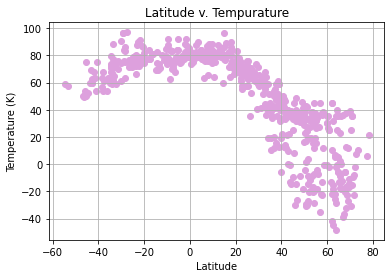

In [39]:
lat = raw_df['City Latitude']
temps = raw_df['Max Tempurature']

plt.scatter(lat, temps, color='plum')
plt.title('Latitude v. Tempurature')
plt.xlabel('Latitude')
plt.ylabel('Temperature (K)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/temps_lat.png', dpi=400)
plt.show()

This plot provides an expected depiction of the change in tempurature v. latitude of the earth. Located at a latitude of 0 degrees, the equator is known to have higher tempuratures relative to other latitudes. What is interesting too see, according to the above graph, though both set of points located at 60 and -60 degrees are equidistant from the equator they do not share similar temperatures. This is most likely due to the southern hemisphere experience its summer during the final/starting months of each year.

## Latitude vs. Humidity Plot

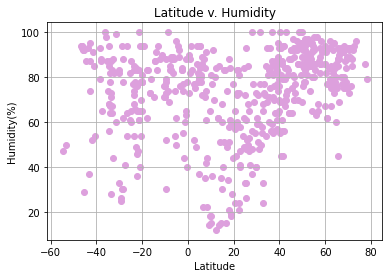

In [40]:
humidity = raw_df['Humidity']

plt.scatter(lat, humidity, color='plum')
plt.title('Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/humidity_lat.png', dpi=400)
plt.show()

The trend of this graph is particularly interesting as it accurately articulates the current weather across the global at the time this data was collected. In the southern hemisphere, there is a wide dispersion of points, signifying no significant change in humidity in that area (this is confirmed by the slope of 0.04 of the regression line in the respective below plot). This is expected as at this time of year the southern hemisphere is experiencing warmer weather which typically brings constant humidity. On the other hand, when considering the northern hemisphere, the points coalesce to a single humidity, about 98% humidity (this is confirmed by the slope of 0.46, nearly a 12x faster increase increase of humidity when moving in consistent increase of latitude, of the regression in line the respective below plot). The high humidity in the north is a typical occurence. 

## Latitude vs. Cloudiness Plot

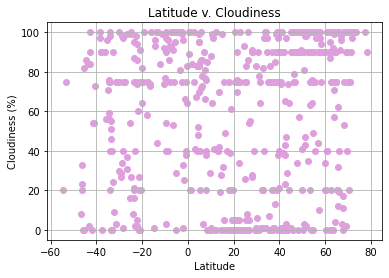

In [41]:
clouds = raw_df['Cloud coverage']

plt.scatter(lat, clouds, color='plum')
plt.title('Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/cloud_lat.png', dpi=400)
plt.show()

## Latitude vs. Wind Speed Plot

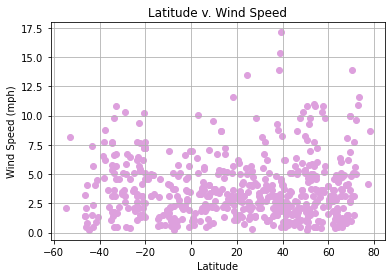

In [42]:
wind_speed = raw_df['Wind speed']

plt.scatter(lat, wind_speed, color='plum')
plt.title('Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/wind_lat.png', dpi=400)
plt.show()

## Linear Regression

In [43]:
n_hem_df = raw_df[raw_df['City Latitude'] > 0]
s_hem_df = raw_df[raw_df['City Latitude'] <= 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

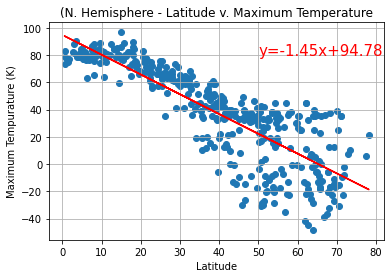

In [44]:
n_lat_max_temp = n_hem_df[['City Latitude','Max Tempurature']]

lat = n_lat_max_temp['City Latitude']
max_temp = n_lat_max_temp['Max Tempurature']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))

plt.scatter(lat, max_temp)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Maximum Temperature')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (50, 80), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_max_temp_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

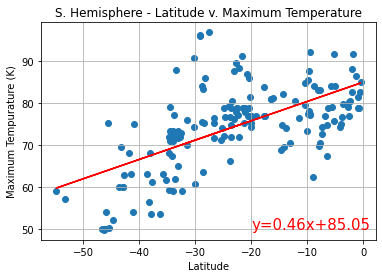

In [45]:
s_lat_max_temp = s_hem_df[['City Latitude','Max Tempurature']]

lat = s_lat_max_temp['City Latitude']
max_temp = s_lat_max_temp['Max Tempurature']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))

plt.scatter(lat, max_temp)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Maximum Temperature')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (-20, 50), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_max_temp_lat.png', dpi=400)
plt.show()

As expected, temperature increases in the southern hemisphere as we approach the equator at latitude 0. What is interesting, however, is the max temperature of this data set is achieved at a latitude of -30 degrees, no where near the equator as expected.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

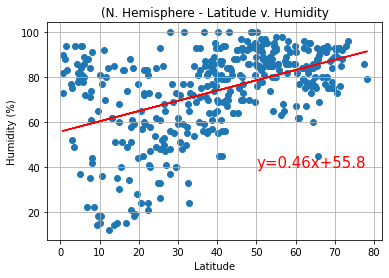

In [46]:
n_lat_humidity = n_hem_df[['City Latitude','Humidity']]

lat = n_lat_humidity['City Latitude']
humidity = n_lat_humidity['Humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, humidity)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (50, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_humidity_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

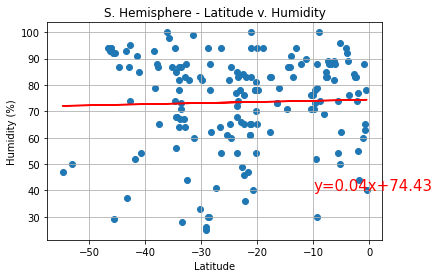

In [47]:
s_lat_humidity = s_hem_df[['City Latitude','Humidity']]

lat = s_lat_humidity['City Latitude']
humidity = s_lat_humidity['Humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, humidity)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (-10, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_humidity_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

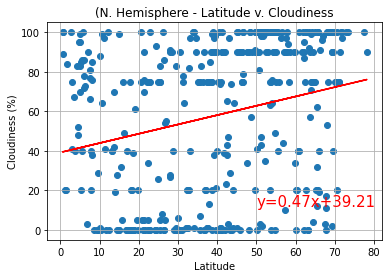

In [48]:
n_lat_cloudiness = n_hem_df[['City Latitude','Cloud coverage']]

lat = n_lat_cloudiness['City Latitude']
cloudiness = n_lat_cloudiness['Cloud coverage']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, cloudiness)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (50, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_cloud_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

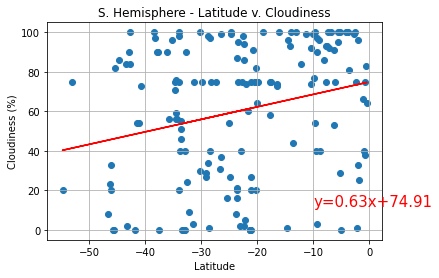

In [49]:
s_lat_cloudiness = s_hem_df[['City Latitude','Cloud coverage']]

lat = s_lat_cloudiness['City Latitude']
cloudiness = s_lat_cloudiness['Cloud coverage']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, cloudiness)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_cloud_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

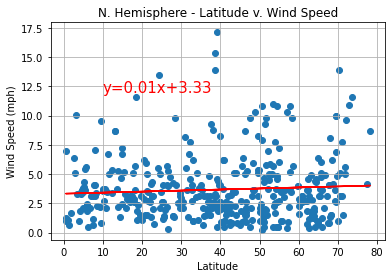

In [50]:
n_lat_wind_speed = n_hem_df[['City Latitude','Wind speed']]

lat = n_lat_wind_speed['City Latitude']
wind_speed = n_lat_wind_speed['Wind speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, wind_speed)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('N. Hemisphere - Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_wind_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

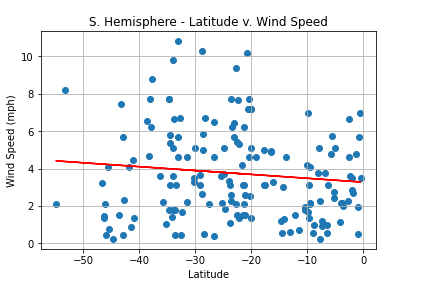

In [51]:
s_lat_wind_speed = s_hem_df[['City Latitude','Wind speed']]

lat = s_lat_wind_speed['City Latitude']
wind_speed = s_lat_wind_speed['Wind speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, wind_speed)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_wind_lat.png', dpi=400)
plt.show()